In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x0.125': load_data('../stats/fpm_4_simplices_x0.5.json'),
    'Num cells x1': load_data('../stats/fpm_4_simplices_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    # 'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [89]:
from fpm_4_simplices import make_model

cell_size_multiplier = 0.5
entry = data[f'Num cells x{cell_size_multiplier ** 3}']

model = make_model(cell_size_multiplier=cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 0.5


num sticking: 0
num sliding: 0
num open: 0
num trans: 14


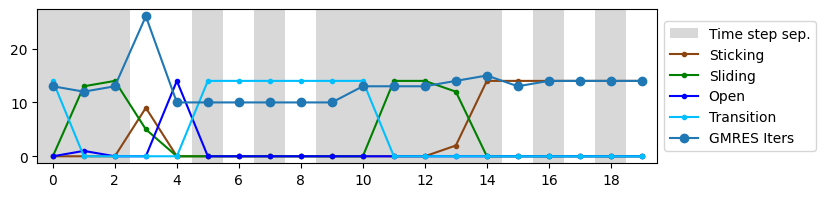

In [90]:
plt.figure(figsize=(8, 2))
# color_sticking_sliding_open_transition(entry)
# color_time_steps(entry, fill=False, legend=True)
plot_sticking_sliding_open_transition(entry)
plt.plot(get_gmres_iterations(entry), marker='o', label='GMRES Iters')
# plt.gca().grid(False)
# plt.ylabel('GMRES iters')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True)

In [92]:
mat_idx = 0
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

13


In [93]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)
model.ad_time_step.set_value(dt)

st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

0
0
0
14


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


LinAlgError: Matrix is singular to machine precision.

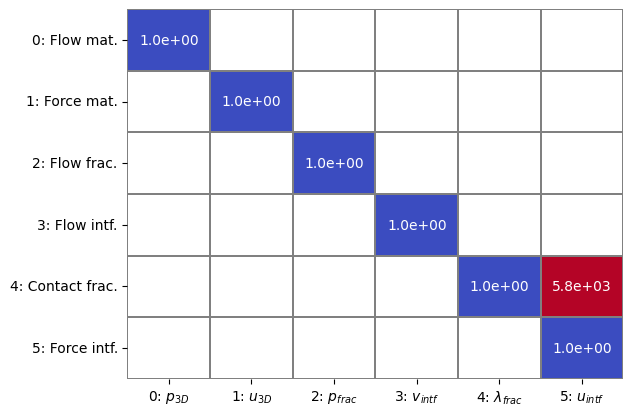

In [94]:
from mat_utils import *

# J = J[[5,1,4,]]
left_side = True

J55_inv = inv_block_diag(J[[5]].mat, nd=model.nd)
# J55_inv = inv(J[[5]].mat)

Q = J.empty_container()
Q.mat = csr_ones(Q.shape[0])
if left_side:
    Q[4, 5] = -J[4, 5].mat @ J55_inv
else:
    Q[5,4] = -J55_inv @ J[5, 4].mat
Q.plot_max()

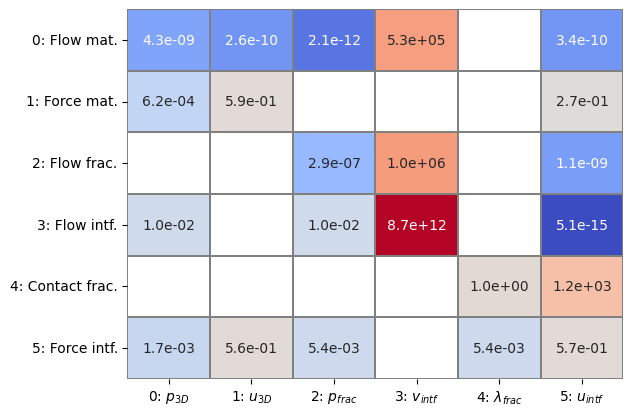

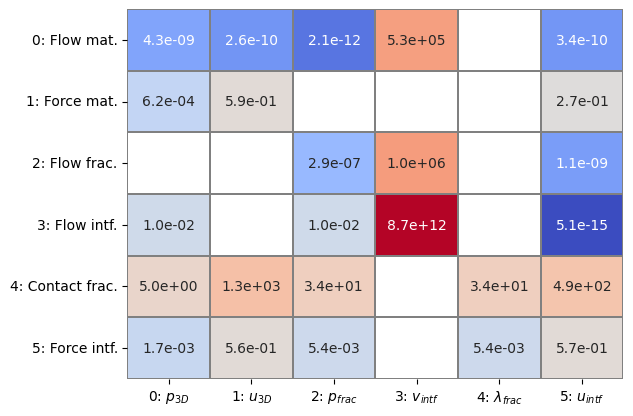

In [82]:
J_Q = J.empty_container()
if left_side:
    J_Q.mat = Q.mat @ J.mat
else:
    J_Q.mat = J.mat @ Q.mat
J.plot_max(); plt.show()
J_Q.plot_max()

Solve  took: 2.61
True residual decrease: 6.250522339107696e-11


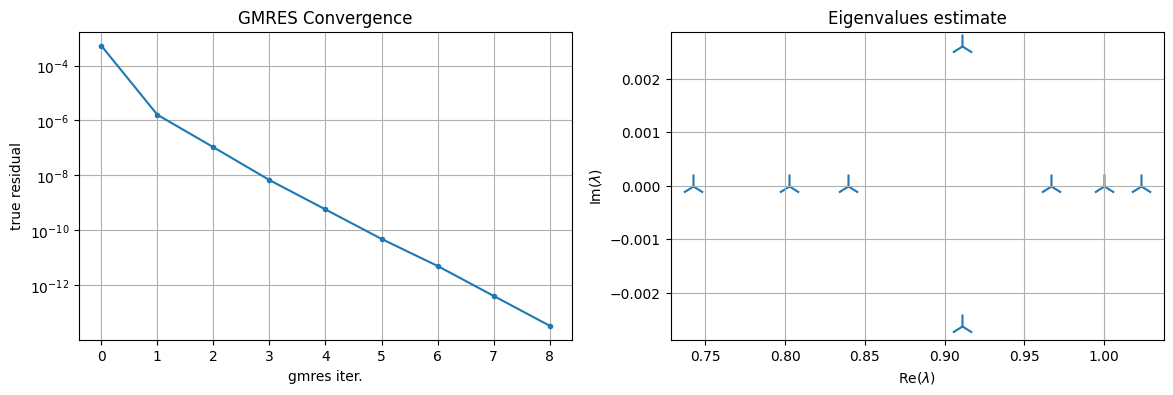

In [87]:
from block_matrix import make_solver, SolveSchema

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: model._fixed_stress.mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

mat_permuted_Q, prec = make_solver(schema, J_Q)

if left_side:
    Q_perm = Q[mat_permuted_Q.active_groups]
    rhs_Q = Q_perm.mat @ Q_perm.local_rhs(rhs)
else:
    rhs_Q = mat_permuted_Q.local_rhs(rhs)


sol_Q = solve_petsc(
    mat_permuted_Q.mat,
    prec=prec,
    rhs=rhs_Q,
    pc_side="right",
    return_solution=True,
    # tol=1e-15
)

if left_side:
    sol = sol_Q
else:
    sol = Q.mat @ sol_Q

In [84]:
np.linalg.norm(mat_permuted_Q.mat @ sol_Q - mat_permuted_Q.local_rhs(rhs)) / np.linalg.norm(mat_permuted_Q.local_rhs(rhs))

3.926873697876482e-09

In [85]:
mat_permuted = J[mat_permuted_Q.active_groups]
np.linalg.norm(mat_permuted.mat @ sol - mat_permuted.local_rhs(rhs)) / np.linalg.norm(mat_permuted.local_rhs(rhs))

5.115443947724074e-09

Right:
$$A \cdot x = b$$
$$x = Q \cdot y $$

$$A\cdot Q \cdot y = b$$

Left:

$$A \cdot x = b$$
$$Q \cdot A \cdot x = Q \cdot b $$